In [1]:
#Author:Bhishma Dedhia

import torch
import torch.nn as nn
import os
import sys
import numpy as np
import argparse
import yaml
from matplotlib import pyplot as plt
sys.path.append('../dsc/')
sys.path.append("../..")
sys.path.append("../../tslib/src/")
sys.path.append("../../tslib/")
sys.path.append(os.getcwd())
from dsc_model import DSCModel
from bert2bert import Bert2BertSynCtrl
from transformers import BertConfig
from src import tsUtils
from src.synthcontrol.syntheticControl import RobustSyntheticControl
from src.synthcontrol.multisyntheticControl import MultiRobustSyntheticControl
%load_ext autoreload
%autoreload 2

In [2]:
#Training noise experiments only on finetuning
noise_array = [0.5,1,2]
for noise in noise_array:
    datapath = f'../datasets/synthetic_data_noise_{noise}/'
    config_path = '../exp_configs/synthetic_noise/config.yaml'
    config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
    op_path = f'../logs_dir/synthetic_noise_{noise}/'
    if not(os.path.exists(op_path)):
        os.mkdir(op_path)
    random_seed = 0
    target_index = 0
    interv_time = 1600
    lowrank = False
    device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
    classes = None
    config_model = BertConfig(hidden_size = config['hidden_size'],
                            num_hidden_layers = config['n_layers'],
                            num_attention_heads = config['n_heads'],
                            intermediate_size = 4*config['hidden_size'],
                            vocab_size = 0,
                            max_position_embeddings = 0,
                            output_hidden_states = True,
                            )

    config_model.add_syn_ctrl_config(K=config['K'],
                                    pre_int_len=config['pre_int_len'],
                                    post_int_len=config['post_int_len'],
                                    feature_dim=config['feature_dim'],
                                    time_range=config['time_range'],
                                    seq_range=config['seq_range'],
                                    cont_dim=config['cont_dim'],
                                    discrete_dim=config['discrete_dim'],
                                    classes = classes)
    model = Bert2BertSynCtrl(config_model, random_seed)
    model = model.to(device)
    dscmodel = DSCModel(model,
                        config,
                        op_path,
                        target_index,
                        random_seed,
                        datapath,
                        device,
                        lowrank = False,
                        classes=None)
    dscmodel.fit(interv_time,pretrain=False)

Modifying K
Fitting model on target unit


RuntimeError: CUDA out of memory. Tried to allocate 12.00 MiB (GPU 0; 39.59 GiB total capacity; 434.53 MiB already allocated; 13.19 MiB free; 452.00 MiB reserved in total by PyTorch)

In [8]:
#Extracting results for Noise experiments
noise_array = [0.5,1,2]
rsc_array = []
mrsc_array = []
dsc_array = []
dsc_no_pretrain = []
mean_array = []
obs_matrix = []
mean_array_full = []

for noise in noise_array:
    datapath = f'../datasets/synthetic_data_noise_{noise}/'
    config_path = '../exp_configs/synthetic_noise/config.yaml'
    config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
    op_path = f'../logs_dir/synthetic_noise_{noise}/'
    if not(os.path.exists(op_path)):
        os.mkdir(op_path)
    random_seed = 0
    target_index = 0
    interv_time = 1600
    lowrank = False
    device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
    classes = None
    config_model = BertConfig(hidden_size = config['hidden_size'],
                            num_hidden_layers = config['n_layers'],
                            num_attention_heads = config['n_heads'],
                            intermediate_size = 4*config['hidden_size'],
                            vocab_size = 0,
                            max_position_embeddings = 0,
                            output_hidden_states = True,
                            )

    config_model.add_syn_ctrl_config(K=config['K'],
                                    pre_int_len=config['pre_int_len'],
                                    post_int_len=config['post_int_len'],
                                    feature_dim=config['feature_dim'],
                                    time_range=config['time_range'],
                                    seq_range=config['seq_range'],
                                    cont_dim=config['cont_dim'],
                                    discrete_dim=config['discrete_dim'],
                                    classes = classes)
    model = Bert2BertSynCtrl(config_model, random_seed)
    model = model.to(device)
    dscmodel = DSCModel(model,
                        config,
                        op_path,
                        target_index,
                        random_seed,
                        datapath,
                        device,
                        lowrank = False,
                        classes=None)

    model_path = f'../logs_dir/synthetic_noise_{noise}/finetune/model.pth'
    dscmodel.load_model_from_checkpoint(model_path)
    op = dscmodel.predict(interv_time)
    if noise == 1:
        np.save(op_path+'target.npy',op)
    obs = np.load(datapath+'obs1.npy')
    obs_matrix.append(obs[0])
    
    model_path = f'../logs_dir/synthetic_noise_{noise}/finetune_only/model.pth'
    dscmodel.load_model_from_checkpoint(model_path)
    op_2 = dscmodel.predict(interv_time)
    
    #MSE
    meanmatrix = np.load(datapath+'mean1.npy')
    test_mean = meanmatrix[0,interv_time:]
    pred_mean=op[interv_time:]
    pred_mean2 = op_2[interv_time:]
    print('With pretraining:',np.sqrt(np.mean((pred_mean - test_mean)**2)))
    print('Without pretraining:',np.sqrt(np.mean((pred_mean2 - test_mean)**2)))
    mean_array_full.append(meanmatrix[0])
    mean_array.append(test_mean)
    dsc_array.append(pred_mean)
    dsc_no_pretrain.append(pred_mean2)
    rsc_array.append(np.load(datapath+'rsc_pred.npy'))
    mrsc_array.append(np.load(datapath+'mrsc_pred.npy'))



Modifying K
With pretraining: 0.31096343503374674
Without pretraining: 1.388517775826949
Modifying K
With pretraining: 0.5836030864688019
Without pretraining: 1.6796841819200345
Modifying K
With pretraining: 0.8345944852565212
Without pretraining: 1.6779314037394235


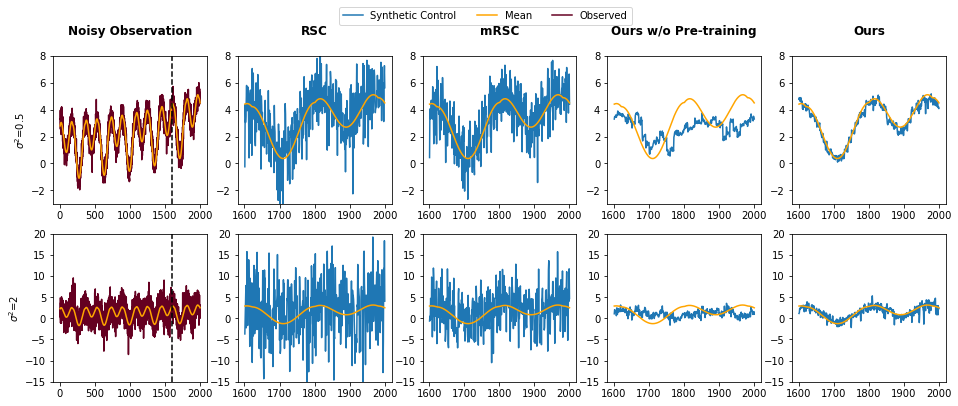

In [4]:
#Plot noise
fig, big_axes = plt.subplots(figsize=(16, 6) , nrows=1, ncols=5, sharey=True) 
x = np.arange(interv_time,2000)+1
x_full =  np.arange(2000)+1
for title, big_ax in zip(['Noisy Observation','RSC', 'mRSC','Ours w/o Pre-training','Ours'], big_axes):
    big_ax.set_title(f'{title}\n', fontweight='semibold')
    big_ax.set_frame_on(False)
    big_ax.axis('off')

noise_array = [0.5,1,2]
custom_ylim = [[-3,8],[-2,8],[-15,20]]

for i in range(1,11,5):
    a1 = fig.add_subplot(2,5,i)
    plt.setp(a1,ylim=custom_ylim[int(i/3)])
    l1=a1.plot(x_full,obs_matrix[int(i/3)],'xkcd:maroon',label='Observed')
    l2=a1.plot(x_full,mean_array_full[int(i/3)],'orange',label='Mean')
    plt.axvline(x =1600,ymin=0, ymax =1 ,linestyle='--',color='black')
    plt.ylabel(f'$\sigma^2$={noise_array[int(i/3)]}')
    #a.legend(loc='lower right')
    a = fig.add_subplot(2,5,i+4)
    plt.setp(a,ylim=custom_ylim[int(i/3)])
    l3=a.plot(x,dsc_array[int(i/3)])
    l4=a.plot(x,mean_array[int(i/3)],'orange',label='Mean')
    
    a = fig.add_subplot(2,5,i+3)
    plt.setp(a,ylim=custom_ylim[int(i/3)])
    l3=a.plot(x,dsc_no_pretrain[int(i/3)])
    l4=a.plot(x,mean_array[int(i/3)],'orange',label='Mean')
    #a.legend(loc='lower right')
    a = fig.add_subplot(2,5,i+1)
    plt.setp(a,ylim=custom_ylim[int(i/3)])
    l5=a.plot(x,rsc_array[int(i/3)])
    l6=a.plot(x,mean_array[int(i/3)],'orange',label='Mean')
    #a.legend(loc='lower right')
    a = fig.add_subplot(2,5,i+2)
    plt.setp(a,ylim=custom_ylim[int(i/3)])
    l7=a.plot(x,mrsc_array[int(i/3)],label='Synthetic Control')
    l8=a.plot(x,mean_array[int(i/3)],'orange',label='Mean')
    #a.legend(loc='lower right')


handles1, labels1 = a.get_legend_handles_labels()
handles2, labels2 = a1.get_legend_handles_labels()
handles1.append(handles2[0])
labels1.append(labels2[0])
fig.legend(handles1,labels1, loc='lower center',ncol=3,bbox_to_anchor=(0.5,0.94))
plt.savefig(f'./figs/noise.pdf',bbox_inches='tight')

plt.show()

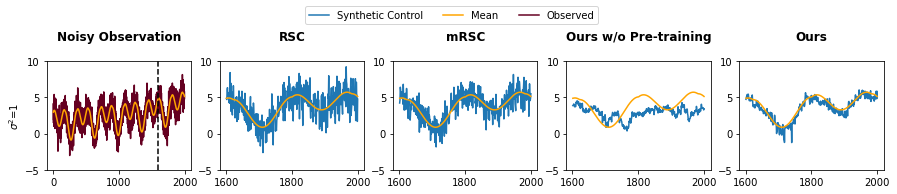

In [9]:
#Plot noise
fig, big_axes = plt.subplots(figsize=(15,2) , nrows=1, ncols=5, sharey=True) 
x = np.arange(interv_time,2000)+1
x_full =  np.arange(2000)+1
for title, big_ax in zip(['Noisy Observation','RSC', 'mRSC','Ours w/o Pre-training','Ours'], big_axes):
    big_ax.set_title(f'{title}\n', fontweight='semibold')
    big_ax.set_frame_on(False)
    big_ax.axis('off')

noise_array = [0.5,1,2]
custom_ylim = [[-3,8],[-5,10],[-15,20]]

a1 = fig.add_subplot(1,5,1)
plt.setp(a1,ylim=custom_ylim[1])
l1=a1.plot(x_full,obs_matrix[1],'xkcd:maroon',label='Observed')
l2=a1.plot(x_full,mean_array_full[1],'orange',label='Mean')
plt.axvline(x =1600,ymin=0, ymax =1 ,linestyle='--',color='black')
plt.ylabel(f'$\sigma^2$={noise_array[1]}')
#a.legend(loc='lower right')
a = fig.add_subplot(1,5,5)
plt.setp(a,ylim=custom_ylim[1])
l3=a.plot(x,dsc_array[1])
l4=a.plot(x,mean_array[1],'orange',label='Mean')

a = fig.add_subplot(1,5,4)
plt.setp(a,ylim=custom_ylim[1])
l3=a.plot(x,dsc_no_pretrain[1])
l4=a.plot(x,mean_array[1],'orange',label='Mean')
#a.legend(loc='lower right')
a = fig.add_subplot(1,5,2)
plt.setp(a,ylim=custom_ylim[1])
l5=a.plot(x,rsc_array[1])
l6=a.plot(x,mean_array[1],'orange',label='Mean')
#a.legend(loc='lower right')
a = fig.add_subplot(1,5,3)
plt.setp(a,ylim=custom_ylim[1])
l7=a.plot(x,mrsc_array[1],label='Synthetic Control')
l8=a.plot(x,mean_array[1],'orange',label='Mean')
#a.legend(loc='lower right')


handles1, labels1 = a.get_legend_handles_labels()
handles2, labels2 = a1.get_legend_handles_labels()
handles1.append(handles2[0])
labels1.append(labels2[0])
fig.legend(handles1,labels1, loc='lower center',ncol=3,bbox_to_anchor=(0.5,1.1))
plt.savefig(f'./figs/noise_one.pdf',bbox_inches='tight')

plt.show()

In [5]:
#N_donor experiments on finetuning only
N_array = [6,16,21,26]

for N in N_array:

    datapath = f'../datasets/synthetic_data_N_{N}/'
    config_path = f'../exp_configs/synthetic_N_{N}/config.yaml'
    config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
    op_path = f'../logs_dir/synthetic_N_{N}/'
    model_path = f'../logs_dir/synthetic_N_{N}/finetune/model.pth'
        
    random_seed = 0
    target_index = 0
    interv_time = 1600
    lowrank = False
    device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
    classes = None
    config_model = BertConfig(hidden_size = config['hidden_size'],
                            num_hidden_layers = config['n_layers'],
                            num_attention_heads = config['n_heads'],
                            intermediate_size = 4*config['hidden_size'],
                            vocab_size = 0,
                            max_position_embeddings = 0,
                            output_hidden_states = True,
                            )

    config_model.add_syn_ctrl_config(K=config['K'],
                                    pre_int_len=config['pre_int_len'],
                                    post_int_len=config['post_int_len'],
                                    feature_dim=config['feature_dim'],
                                    time_range=config['time_range'],
                                    seq_range=config['seq_range'],
                                    cont_dim=config['cont_dim'],
                                    discrete_dim=config['discrete_dim'],
                                    classes = classes)
    model = Bert2BertSynCtrl(config_model, random_seed)
    model = model.to(device)
    dscmodel = DSCModel(model,
                        config,
                        op_path,
                        target_index,
                        random_seed,
                        datapath,
                        device,
                        lowrank = False,
                        classes=None)
    
    
    dscmodel.fit(interv_time,pretrain=False)
    




Modifying K
Fitting model on target unit
Iteration:0	Loss_mean:0.47808441519737244	Loss_std:0.0
Iteration:100	Loss_mean:0.1335410394333303	Loss_std:0.11944479969828967
Iteration:200	Loss_mean:0.0678761412575841	Loss_std:0.03536519881798309
Iteration:300	Loss_mean:0.041770495362579825	Loss_std:0.022595891205270766
Iteration:400	Loss_mean:0.03556770649272949	Loss_std:0.020016784585532663
Iteration:500	Loss_mean:0.030713852532207965	Loss_std:0.019233819123311523
Iteration:600	Loss_mean:0.0261569142434746	Loss_std:0.019847186684576492
Iteration:700	Loss_mean:0.023568398817442358	Loss_std:0.017233744514775513
Iteration:800	Loss_mean:0.021678978169802576	Loss_std:0.015736712347163204
Iteration:900	Loss_mean:0.02528251350624487	Loss_std:0.02183888417837275
Iteration:1000	Loss_mean:0.019754594936966897	Loss_std:0.013725144122738614
Iteration:1100	Loss_mean:0.02108183007221669	Loss_std:0.01710902635532872
Iteration:1200	Loss_mean:0.02226625819923356	Loss_std:0.018511761720091335
Iteration:1300	

Iteration:900	Loss_mean:0.019433379732072355	Loss_std:0.014489156643626135
Iteration:1000	Loss_mean:0.019304417312378065	Loss_std:0.015075710711851306
Iteration:1100	Loss_mean:0.01684107691515237	Loss_std:0.014862045811774758
Iteration:1200	Loss_mean:0.01855403566500172	Loss_std:0.01405919435436894
Iteration:1300	Loss_mean:0.017822172155138104	Loss_std:0.012945815002649241
Iteration:1400	Loss_mean:0.018011429369216785	Loss_std:0.01425906436866676
Iteration:1500	Loss_mean:0.016818023350788282	Loss_std:0.01769881727215715
Iteration:1600	Loss_mean:0.015173756282310933	Loss_std:0.017140846194781255
Iteration:1700	Loss_mean:0.015510990747716278	Loss_std:0.014445034666701728
Iteration:1800	Loss_mean:0.013462708356091752	Loss_std:0.011877861585106765
Iteration:1900	Loss_mean:0.01458780116168782	Loss_std:0.012452860794543793
Iteration:2000	Loss_mean:0.01432557518593967	Loss_std:0.011888127276864027
Iteration:2100	Loss_mean:0.016302867009362672	Loss_std:0.013652149895866323
Iteration:2200	Loss_

Iteration:1800	Loss_mean:0.0140796067006886	Loss_std:0.011701578689965903
Iteration:1900	Loss_mean:0.01799050531350076	Loss_std:0.014120318319911344
Iteration:2000	Loss_mean:0.01774345104699023	Loss_std:0.016552582466354066
Iteration:2100	Loss_mean:0.015019544947426767	Loss_std:0.012097053160043766
Iteration:2200	Loss_mean:0.01818027856061235	Loss_std:0.013261509607747959
Iteration:2300	Loss_mean:0.015920101926312782	Loss_std:0.01263266272990635
Iteration:2400	Loss_mean:0.017654311736114325	Loss_std:0.013908454442182751
Iteration:2500	Loss_mean:0.015959901101887226	Loss_std:0.013035155242879178
Iteration:2600	Loss_mean:0.015688551204511895	Loss_std:0.01347546441717042
Iteration:2700	Loss_mean:0.015815758695825934	Loss_std:0.012367282287700778
Iteration:2800	Loss_mean:0.0135373393795453	Loss_std:0.009186652968550021
Iteration:2900	Loss_mean:0.011427937811240553	Loss_std:0.008104036804715513
Iteration:3000	Loss_mean:0.015239528666716068	Loss_std:0.013746499486472353
Iteration:3100	Loss_m

Iteration:2700	Loss_mean:0.016513822764973155	Loss_std:0.013491210052993285
Iteration:2800	Loss_mean:0.015370576099958271	Loss_std:0.013705612546444987
Iteration:2900	Loss_mean:0.016952344832243397	Loss_std:0.013298371654038904
Iteration:3000	Loss_mean:0.0172495565447025	Loss_std:0.015786831105295284
Iteration:3100	Loss_mean:0.015013949864223832	Loss_std:0.01271450148549995
Iteration:3200	Loss_mean:0.01499387520365417	Loss_std:0.012002164942993361
Iteration:3300	Loss_mean:0.01722919903928414	Loss_std:0.01409500472064523
Iteration:3400	Loss_mean:0.015609335935441776	Loss_std:0.012079231365577186
Iteration:3500	Loss_mean:0.016453798122238367	Loss_std:0.014233624617439771
Iteration:3600	Loss_mean:0.015487794836517424	Loss_std:0.01217049920893722
Iteration:3700	Loss_mean:0.015305968665052206	Loss_std:0.012455213209083849
Iteration:3800	Loss_mean:0.014769680625759065	Loss_std:0.011445025474754244
Iteration:3900	Loss_mean:0.014659939515404403	Loss_std:0.01258163940404078
Iteration:4000	Loss_

In [2]:
#Extract results
N_array = [6,11,16,21,26]
rsc_array = []
mrsc_array = []
dsc_array = []
dsc_no_pretrain = []
mean_array = []
obs_matrix = []
mean_array_full = []

for N in N_array:
    
    if N==11:
        datapath = '../datasets/synthetic_data_noise_1/'
        config_path = '../exp_configs/synthetic_noise/config.yaml'
        config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
        op_path = '../logs_dir/synthetic/'
        if not(os.path.exists(op_path)):
            os.mkdir(op_path)
        random_seed = 0
        target_index = 0
        interv_time = 1600
        lowrank = False
        model_path = '../logs_dir/synthetic_noise_1/finetune/model.pth'
        model_path_finetune_only = '../logs_dir/synthetic_noise_1/finetune_only/model.pth'
    else:
        
        datapath = f'../datasets/synthetic_data_N_{N}/'
        config_path = f'../exp_configs/synthetic_N_{N}/config.yaml'
        config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
        op_path = f'../logs_dir/synthetic_N_{N}/'
        model_path = f'../logs_dir/synthetic_N_{N}/finetune/model.pth'
        model_path_finetune_only = f'../logs_dir/synthetic_N_{N}/finetune_only/model.pth'

        random_seed = 0
        target_index = 0
        interv_time = 1600
        lowrank = False
        
    device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
    classes = None
    config_model = BertConfig(hidden_size = config['hidden_size'],
                            num_hidden_layers = config['n_layers'],
                            num_attention_heads = config['n_heads'],
                            intermediate_size = 4*config['hidden_size'],
                            vocab_size = 0,
                            max_position_embeddings = 0,
                            output_hidden_states = True,
                            )

    config_model.add_syn_ctrl_config(K=config['K'],
                                    pre_int_len=config['pre_int_len'],
                                    post_int_len=config['post_int_len'],
                                    feature_dim=config['feature_dim'],
                                    time_range=config['time_range'],
                                    seq_range=config['seq_range'],
                                    cont_dim=config['cont_dim'],
                                    discrete_dim=config['discrete_dim'],
                                    classes = classes)
    model = Bert2BertSynCtrl(config_model, random_seed)
    model = model.to(device)
    dscmodel = DSCModel(model,
                        config,
                        op_path,
                        target_index,
                        random_seed,
                        datapath,
                        device,
                        lowrank = False,
                        classes=None)

   
    dscmodel.load_model_from_checkpoint(model_path)
    op = dscmodel.predict(interv_time)
    obs = np.load(datapath+'obs1.npy')
    obs_matrix.append(obs[0])
    
    
    dscmodel.load_model_from_checkpoint(model_path_finetune_only)
    op_2 = dscmodel.predict(interv_time)
    
    #MSE
    meanmatrix = np.load(datapath+'mean1.npy')
    test_mean = meanmatrix[0,interv_time:]
    pred_mean=op[interv_time:]
    pred_mean2 = op_2[interv_time:]
    print('With pretraining:',np.sqrt(np.mean((pred_mean - test_mean)**2)))
    print('Without pretraining:',np.sqrt(np.mean((pred_mean2 - test_mean)**2)))
    mean_array_full.append(meanmatrix[0])
    mean_array.append(test_mean)
    dsc_array.append(pred_mean)
    dsc_no_pretrain.append(pred_mean2)
    rsc_array.append(np.load(datapath+'rsc_pred.npy'))
    mrsc_array.append(np.load(datapath+'mrsc_pred.npy'))



Modifying K
With pretraining: 0.6922576535473619
Without pretraining: 1.5596011903243483
Modifying K
With pretraining: 0.5836030864688019
Without pretraining: 1.6796841819200345
Modifying K
With pretraining: 0.7655564070850502
Without pretraining: 1.6058662653697986
Modifying K
With pretraining: 0.5519794588004132
Without pretraining: 2.074000557009957
Modifying K
With pretraining: 0.5009042315184637
Without pretraining: 1.373422975972848


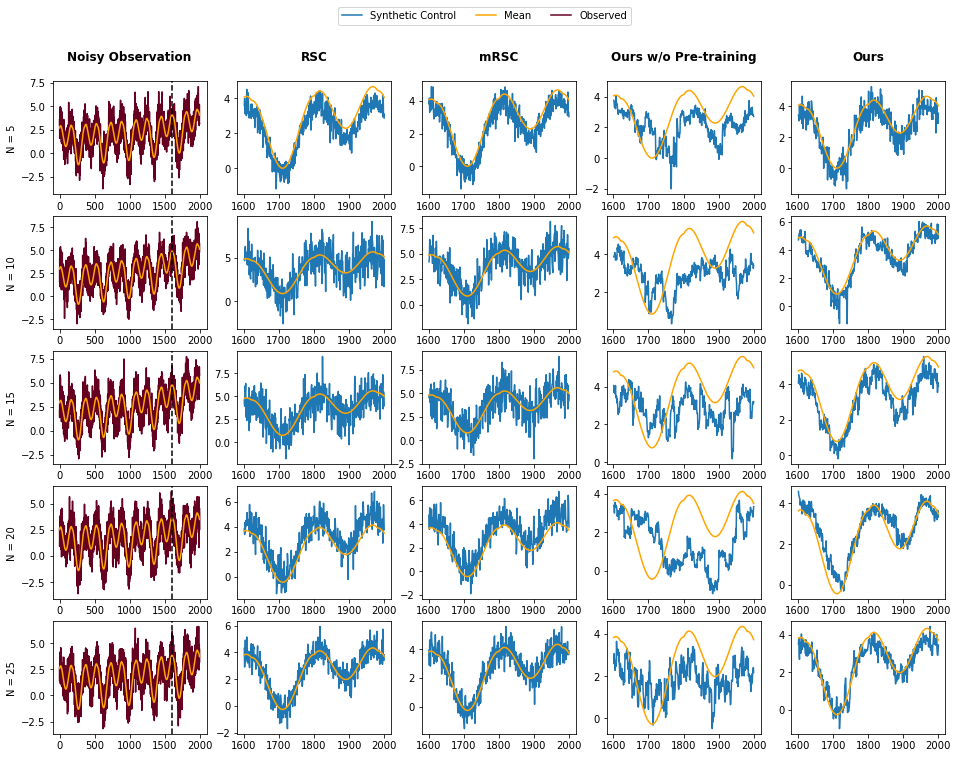

In [11]:
#Plots
fig, big_axes = plt.subplots(figsize=(16, 12) , nrows=1, ncols=5, sharey=True) 
x = np.arange(interv_time,2000)+1
x_full =  np.arange(2000)+1
for title, big_ax in zip(['Noisy Observation','RSC', 'mRSC','Ours w/o Pre-training','Ours'], big_axes):
    big_ax.set_title(f'{title}\n', fontweight='semibold')
    big_ax.set_frame_on(False)
    big_ax.axis('off')

#custom_ylim = [[-3,8],[-2,8],[-15,20]]
N_array = [5,10,15,20,25]
for i in range(1,26,5):
        a1 = fig.add_subplot(5,5,i)
        #plt.setp(a1,ylim=custom_ylim[int(i/4)])
        l1=a1.plot(x_full,obs_matrix[int(i/5)],'xkcd:maroon',label='Observed')
        l2=a1.plot(x_full,mean_array_full[int(i/5)],'orange',label='Mean')
        plt.axvline(x =1600,ymin=0, ymax =1 ,linestyle='--',color='black')
        plt.ylabel(f'N = {N_array[int(i/5)]}')
        #a.legend(loc='lower right')
        a = fig.add_subplot(5,5,i+4)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l3=a.plot(x,dsc_array[int(i/5)])
        l4=a.plot(x,mean_array[int(i/5)],'orange',label='Mean')
        a = fig.add_subplot(5,5,i+3)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l3=a.plot(x,dsc_no_pretrain[int(i/5)])
        l4=a.plot(x,mean_array[int(i/5)],'orange',label='Mean')
        #a.legend(loc='lower right')
        a = fig.add_subplot(5,5,i+1)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l5=a.plot(x,rsc_array[int(i/5)])
        l6=a.plot(x,mean_array[int(i/5)],'orange',label='Mean')
        #a.legend(loc='lower right')
        a = fig.add_subplot(5,5,i+2)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l7=a.plot(x,mrsc_array[int(i/5)],label='Synthetic Control')
        l8=a.plot(x,mean_array[int(i/5)],'orange',label='Mean')
        #a.legend(loc='lower right')


handles1, labels1 = a.get_legend_handles_labels()
handles2, labels2 = a1.get_legend_handles_labels()
handles1.append(handles2[0])
labels1.append(labels2[0])
fig.legend(handles1,labels1, loc='lower center',ncol=3,bbox_to_anchor=(0.5,0.94))
plt.savefig(f'./figs/donorpool_all.pdf',bbox_inches='tight')

plt.show()

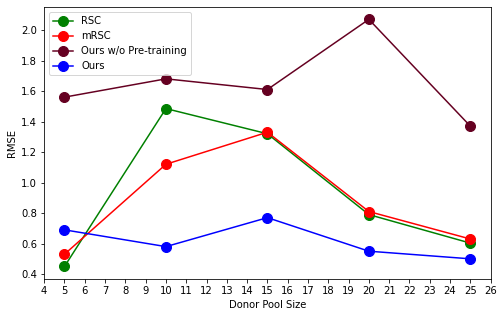

In [3]:
dsc= [0.69,0.58,0.77,0.55,0.5]
dsc_no_pretrain = [1.56,1.68,1.61,2.07,1.37]
msc = [0.53,1.12,1.33,0.81,0.63]
rsc = [0.45,1.485, 1.32 ,0.79, 0.603]
N = [5,10,15,20,25]
yint = range(3,28)
plt.figure(figsize=(8, 5))
plt.xticks(yint)

plt.plot(N,rsc,'og-',label='RSC',markersize=10)
plt.plot(N,msc,'or-',label='mRSC',markersize=10)
plt.plot(N,dsc_no_pretrain,color='xkcd:maroon',marker='o',label='Ours w/o Pre-training',markersize=10)
plt.plot(N,dsc,'ob-',label='Ours',markersize=10)
plt.xlabel('Donor Pool Size')
plt.ylabel('RMSE')
plt.legend()
plt.savefig(f'./figs/donorpool.pdf',bbox_inches='tight')

In [7]:
missing_array = [0.1,0.2,0.3,0.5]
rsc_array = []
mrsc_array = []
dsc_array = []
dsc_no_pretrain = []
mean_array = []
obs_matrix = []
mean_array_full = []
obs_x = []

for p in missing_array:
    
    datapath = f'../datasets/synthetic_data_missing_{p}/'
    config_path = f'../exp_configs/synthetic_noise/config.yaml'
    config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
    op_path = f'../logs_dir/synthetic_missing_{p}/'
    model_path = f'../logs_dir/synthetic_missing_{p}/finetune/model.pth'
    #model_path_finetune_only =  f'../logs_dir/synthetic_missing_{p}/finetune_only/model.pth'
    random_seed = 0
    target_index = 0
    interv_time = 1600
    lowrank = True
    device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
    classes = None
    config_model = BertConfig(hidden_size = config['hidden_size'],
                            num_hidden_layers = config['n_layers'],
                            num_attention_heads = config['n_heads'],
                            intermediate_size = 4*config['hidden_size'],
                            vocab_size = 0,
                            max_position_embeddings = 0,
                            output_hidden_states = True,
                            )

    config_model.add_syn_ctrl_config(K=config['K'],
                                    pre_int_len=config['pre_int_len'],
                                    post_int_len=config['post_int_len'],
                                    feature_dim=config['feature_dim'],
                                    time_range=config['time_range'],
                                    seq_range=config['seq_range'],
                                    cont_dim=config['cont_dim'],
                                    discrete_dim=config['discrete_dim'],
                                    classes = classes)
    model = Bert2BertSynCtrl(config_model, random_seed)
    model = model.to(device)
    dscmodel = DSCModel(model,
                        config,
                        op_path,
                        target_index,
                        random_seed,
                        datapath,
                        device,
                        lowrank = True,
                        classes=None)
    interv_time = 1600
    dscmodel.load_model_from_checkpoint(model_path)
    op = dscmodel.predict(interv_time)
    mask = np.load(datapath+'mask.npy')
    mask_target = mask[0,:,0]
    obs = np.load(datapath+'data.npy')[:,:,0]
    obs_matrix.append(obs[0][mask_target==0])
    print()
    x_full =  np.arange(2000)+1
    obs_x.append(x_full[mask_target==0])
    #dscmodel.load_model_from_checkpoint(model_path_finetune_only)
    #op_2 = dscmodel.predict(interv_time)
    
    #MSE
    meanmatrix = np.load(datapath+'mean1.npy')
    test_mean = meanmatrix[0,interv_time:]
    pred_mean=op[interv_time:]
    #pred_mean2 = op_2[interv_time:]
    print('With pretraining:',np.sqrt(np.mean((pred_mean - test_mean)**2)))
    #print('Without pretraining:',np.sqrt(np.mean((pred_mean2 - test_mean)**2)))
    mean_array_full.append(meanmatrix[0])
    mean_array.append(test_mean)
    dsc_array.append(pred_mean)
    #dsc_no_pretrain.append(pred_mean2)
    rsc_array.append(np.load(datapath+'rsc_pred.npy'))
    mrsc_array.append(np.load(datapath+'mrsc_pred.npy'))

Modifying K
Low rank conversion done

With pretraining: 0.6766517547135652
Modifying K
Low rank conversion done

With pretraining: 1.1063805646149456
Modifying K
Low rank conversion done

With pretraining: 1.4240025116088657
Modifying K
Low rank conversion done

With pretraining: 2.339607841200911


In [5]:
missing_array = [0.1,0.2,0.3,0.5]
rsc_array = []
mrsc_array = []
dsc_array = []
dsc_no_pretrain = []
mean_array = []
obs_matrix = []
mean_array_full = []
obs_x = []

for p in missing_array:
    
    datapath = f'../datasets/synthetic_data_missing_{p}/'
    config_path = f'../exp_configs/synthetic_noise/config.yaml'
    config = yaml.load(open(config_path,'r'),Loader=yaml.FullLoader)
    op_path = f'../logs_dir/synthetic_missing_{p}_no_denoising/'
    model_path =  f'../logs_dir/synthetic_missing_{p}_no_denoising/finetune/model.pth'
    random_seed = 0
    target_index = 0
    interv_time = 1600
    lowrank = True
    device = torch.device('cuda:0' if torch.cuda.is_available else "cpu")
    classes = None
    config_model = BertConfig(hidden_size = config['hidden_size'],
                            num_hidden_layers = config['n_layers'],
                            num_attention_heads = config['n_heads'],
                            intermediate_size = 4*config['hidden_size'],
                            vocab_size = 0,
                            max_position_embeddings = 0,
                            output_hidden_states = True,
                            )

    config_model.add_syn_ctrl_config(K=config['K'],
                                    pre_int_len=config['pre_int_len'],
                                    post_int_len=config['post_int_len'],
                                    feature_dim=config['feature_dim'],
                                    time_range=config['time_range'],
                                    seq_range=config['seq_range'],
                                    cont_dim=config['cont_dim'],
                                    discrete_dim=config['discrete_dim'],
                                    classes = classes)
    model = Bert2BertSynCtrl(config_model, random_seed)
    model = model.to(device)
    dscmodel = DSCModel(model,
                        config,
                        op_path,
                        target_index,
                        random_seed,
                        datapath,
                        device,
                        lowrank =False,
                        classes=None)
    interv_time = 1600
    dscmodel.load_model_from_checkpoint(model_path)
    op = dscmodel.predict(interv_time)
    #MSE
    meanmatrix = np.load(datapath+'mean1.npy')
    test_mean = meanmatrix[0,interv_time:]
    pred_mean=op[interv_time:]
    print('Without denoising:',np.sqrt(np.mean((pred_mean - test_mean)**2)))


Modifying K
Without denoising: 1.2642723143818673
Modifying K
Without denoising: 1.4538390658644265
Modifying K
Without denoising: 1.51629301726511
Modifying K
Without denoising: 3.3510035422132067


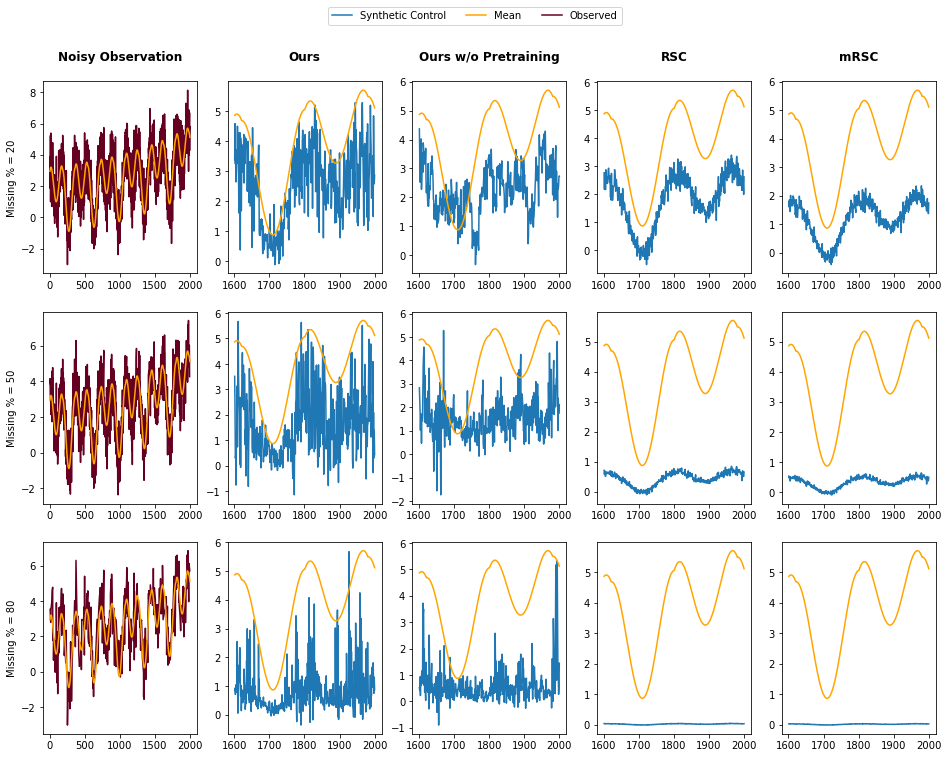

In [18]:
#Plots
fig, big_axes = plt.subplots(figsize=(16, 12) , nrows=1, ncols=5, sharey=True) 
x = np.arange(interv_time,2000)+1
x_full =  np.arange(2000)+1
for title, big_ax in zip(['Noisy Observation','Ours','Ours w/o Pretraining','RSC', 'mRSC'], big_axes):
    big_ax.set_title(f'{title}\n', fontweight='semibold')
    big_ax.set_frame_on(False)
    big_ax.axis('off')

p_array = [0.2,0.5,0.8]
for i in range(1,16,5):
        a1 = fig.add_subplot(3,5,i)
        #plt.setp(a1,ylim=custom_ylim[int(i/4)])
        l1=a1.plot(obs_x[int(i/5)],obs_matrix[int(i/5)],'xkcd:maroon',label='Observed')
        l2=a1.plot(x_full,mean_array_full[int(i/5)],'orange',label='Mean')
        plt.ylabel(f'Missing % = {int(p_array[int(i/5)]*100)}')
        #a.legend(loc='lower right')
        a = fig.add_subplot(3,5,i+1)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l3=a.plot(x,dsc_array[int(i/5)])
        l4=a.plot(x,mean_array[int(i/5)],'orange',label='Mean')
        a = fig.add_subplot(3,5,i+2)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l3=a.plot(x,dsc_no_pretrain[int(i/5)])
        l4=a.plot(x,mean_array[int(i/5)],'orange',label='Mean')
        #a.legend(loc='lower right')
        a = fig.add_subplot(3,5,i+3)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l5=a.plot(x,rsc_array[int(i/5)])
        l6=a.plot(x,mean_array[int(i/5)],'orange',label='Mean')
        #a.legend(loc='lower right')
        a = fig.add_subplot(3,5,i+4)
        #plt.setp(a,ylim=custom_ylim[int(i/4)])
        l7=a.plot(x,mrsc_array[int(i/5)],label='Synthetic Control')
        l8=a.plot(x,mean_array[int(i/5)],'orange',label='Mean')
        #a.legend(loc='lower right')


handles1, labels1 = a.get_legend_handles_labels()
handles2, labels2 = a1.get_legend_handles_labels()
handles1.append(handles2[0])
labels1.append(labels2[0])
fig.legend(handles1,labels1, loc='lower center',ncol=3,bbox_to_anchor=(0.5,0.94))
plt.savefig(f'./figs/missing.pdf',bbox_inches='tight')

plt.show()